In [1]:
import numpy as np
from numpy.linalg.linalg import LinAlgError
import torch
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
import copy

In [3]:
def make_hssn2(x,f,N): # 多変数版のヘッセ行列の計算
    hs = np.zeros([N,N], dtype = 'float32')
    g = torch.autograd.grad(f,x,create_graph = True)
    grad = g[0].detach().numpy()
    for i in range(N):
        h = torch.autograd.grad(g[0][i], x, retain_graph = True)
        hs[i] = np.array_split(h[0].detach().numpy(),N)    
    return hs, grad

def make_hssn(x,y,f): # 二変数版のヘッセ行列の計算
    hs = torch.zeros([2,2], dtype = torch.float32)
    g = torch.autograd.grad(f, (x,y), create_graph = True)
    grad = torch.tensor([g[0],g[1]])
    h1 = torch.autograd.grad(g[0], (x,y) ,retain_graph=True)
    h2 = torch.autograd.grad(g[1], (x,y),retain_graph=True)

    hs[0][0] = h1[0]
    hs[0][1] = h1[1]

    hs[1][0] = h2[0]
    hs[1][1] = h2[1]

    return hs,grad

def chol_mdfy(hs,N): # Cholesky分解を用いた修正行列の計算
    a_min = np.diagonal(hs).min() 
    beta = 10**-3
    if a_min > 0:
        t = 0   
    else:
        t = beta-a_min
    id = np.identity(N)
    for i in range(100):
        hs += t*id
        try:
            l = np.linalg.cholesky(hs)
        except LinAlgError as err:
            print(err)
            t = max(2*t,beta)
            continue
        else:
            print("success")
            return l

def chol_nwt(x,func,num_epoch,hstry,N):
    for i in range(num_epoch):
        f = func(x)
        hs,grad = make_hssn2(x,f,N)
        l = chol_mdfy(hs,N)
        s = np.linalg.solve(l, grad)
        t = np.linalg.solve(l.T, s)
        x = x - torch.from_numpy(t)
        hstry = np.vstack((hstry,np.array(x[0:N].detach()).copy()))
    return hstry


In [4]:
def func(x):
    return 100*(x[1] - x[0]**2)**2+(1 - x[0])**2

def func2(x):
    return x[0]**2 + x[0]*x[1] + x[1]**2

def func3(x):
    return x[0]**4 + x[0]*x[1]**3 + 2*x[0]*x[1] + x[1]**4

In [5]:
x = torch.tensor([2.,2.], requires_grad=True)

hstry = np.array(x[:].detach()).copy()
num_epoch = 100
hstry = chol_nwt(x, func, num_epoch, hstry,2)

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


/tmp/ipykernel_3719/2220844516.py:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  hs[i] = np.array_split(h[0].detach().numpy(),N)


[1. 1.]


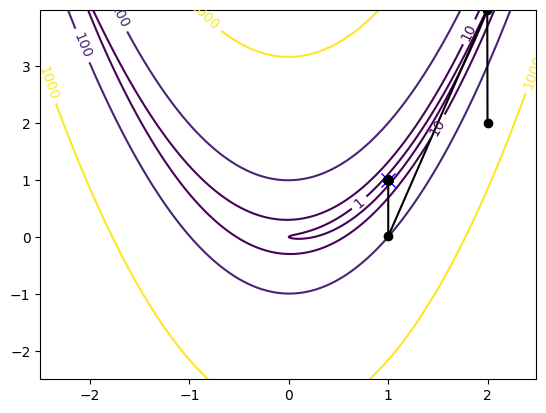

In [6]:
print(hstry[-1])

x = np.arange(-2.5, 2.5, 0.01)
y = np.arange(-2.5, 4, 0.01)
X, Y = np.meshgrid(x, y)
Z = func([X,Y])

fig, ax = plt.subplots()
#levs = 10**np.arange(0,10,0.25)
levs = np.array([0,1,10,100,1000])
cs= ax.contour(X,Y,Z,levels =levs)
ax.clabel(cs, inline=True, fontsize=10)
plt.plot(1,1,marker = 'x', c = 'b',markersize = 10)
plt.plot(hstry[:,0],hstry[:,1],marker='o', c = 'k')
#plt.savefig("cholesky_nwt.eps")

[[2.         2.        ]
 [0.39799991 2.4000001 ]
 [0.75606596 1.95168078]
 ...
 [1.11150825 1.23586786]
 [1.1114707  1.23578441]
 [1.11143327 1.23570096]]


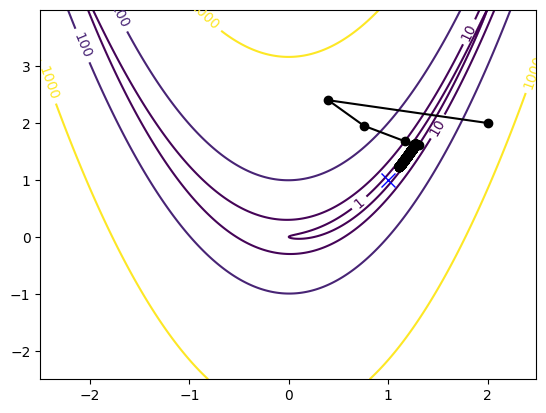

In [7]:
x2 = torch.tensor([2.,2.], requires_grad=True)
prms = [x2]
hstry2 = np.array([x2[0].item(), x2[1].item()]).copy()
optim = torch.optim.SGD(prms, lr=0.001)
for i in range(3000):
    optim.zero_grad()
    output = func(x2)
    output.backward()
    optim.step()
    hstry2 = np.vstack((hstry2,np.array([x2[0].item(), x2[1].item()]).copy()))
print(hstry2)

fig, ax = plt.subplots()
cs= ax.contour(X,Y,Z,levels = levs)
ax.clabel(cs, inline=True, fontsize=10)
plt.plot(1,1,marker='x', c = 'b', markersize = 10)
plt.plot(hstry2[:,0],hstry2[:,1],marker='o', c = 'k')
#plt.savefig("stp_GD.eps")

[[2.         2.        ]
 [1.         3.        ]
 [0.73318076 2.94736838]
 ...
 [0.9999997  0.9999994 ]
 [0.9999997  0.9999994 ]
 [0.9999997  0.9999994 ]]


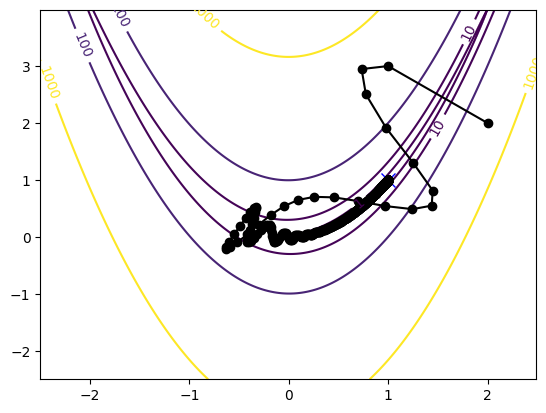

In [8]:
x3 = torch.tensor([2.,2.], requires_grad=True)
prms = [x3]
optim = torch.optim.Adam(prms, lr=1)
hstry3 = np.array([x3[0].item(), x3[1].item()]).copy()
for i in range(2000):
    optim.zero_grad()
    output = func(x3)
    output.backward()
    optim.step()
    hstry3 = np.vstack((hstry3,np.array([x3[0].item(), x3[1].item()]).copy()))
print(hstry3)

fig, ax = plt.subplots()
cs= ax.contour(X,Y,Z,levels =levs)
ax.clabel(cs, inline=True, fontsize=10)
plt.plot(1,1,marker='x', c = 'b', markersize=10)
plt.plot(hstry3[:,0],hstry3[:,1],marker='o', c = 'k')
#plt.savefig("Adam.eps")

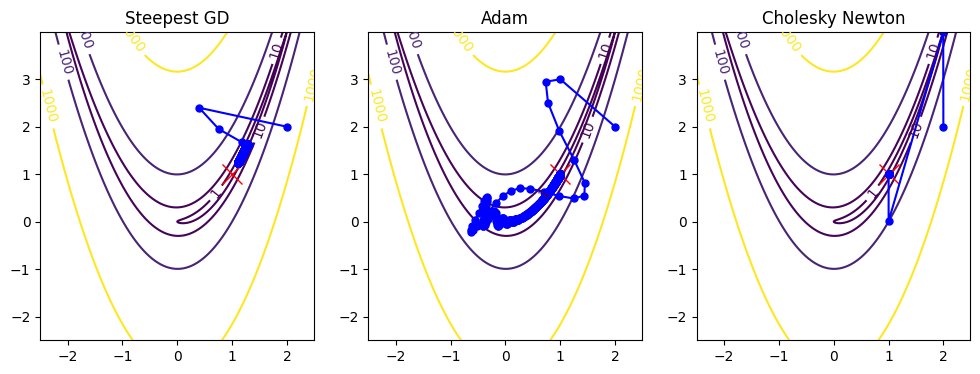

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex = False, figsize=(12.0,4.0))
markersize=5
mrksiz_sol = 15
cl_solution='r'
ax[2].set_title("Cholesky Newton")
cs= ax[2].contour(X,Y,Z,levels =levs)
ax[2].clabel(cs, inline=True, fontsize=10)
ax[2].plot(1,1,marker='x', c = cl_solution, markersize=mrksiz_sol)
ax[2].plot(hstry[:,0],hstry[:,1],marker='o', c = 'b',markersize = markersize)

ax[0].set_title("Steepest GD")
cs= ax[0].contour(X,Y,Z,levels =levs)
ax[0].clabel(cs, inline=True, fontsize=10)
ax[0].plot(1,1,marker='x', c = cl_solution, markersize=mrksiz_sol)
ax[0].plot(hstry2[:,0],hstry2[:,1],marker='o', c = 'b', markersize = markersize)

ax[1].set_title("Adam")
cs= ax[1].contour(X,Y,Z,levels =levs)
ax[1].clabel(cs, inline=True, fontsize=10)
ax[1].plot(1,1,marker='x', c = cl_solution, markersize=mrksiz_sol)
ax[1].plot(hstry3[:,0],hstry3[:,1],marker='o', c = 'b',markersize = markersize)
#plt.savefig("convergence_RB.eps")

In [10]:
# 初期値を離してみる実験
x = torch.tensor([-1000.,8.], requires_grad=True)
hstry = np.array(x[:].detach()).copy()
num_epoch = 100
hstry = chol_nwt(x, func, num_epoch, hstry,2)

success
Matrix is not positive definite
success
success
success
success
success
Matrix is not positive definite
success
success
success
Matrix is not positive definite
success
success
success
success
success
success
success
success
success
Matrix is not positive definite
success
success
success
success
success
Matrix is not positive definite
success
success
success
success
success
success
success
Matrix is not positive definite
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


/tmp/ipykernel_3719/2220844516.py:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  hs[i] = np.array_split(h[0].detach().numpy(),N)


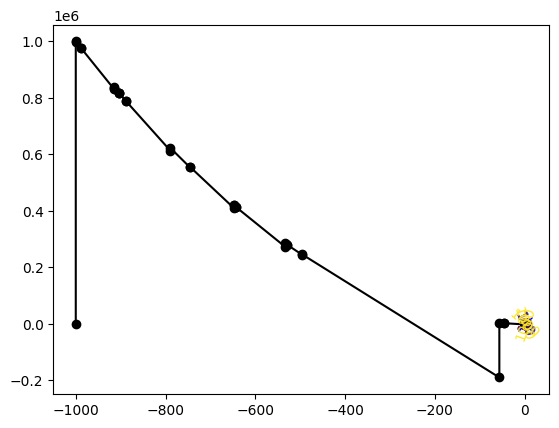

In [11]:
fig, ax = plt.subplots()
#levs = 10**np.arange(0,10,0.25)
levs = np.array([0,1,10,100,1000])
cs= ax.contour(X,Y,Z,levels =levs)
ax.clabel(cs, inline=True, fontsize=10)
plt.plot(1,1,marker = 'x', c = 'b',markersize = 10)
plt.plot(hstry[:,0],hstry[:,1],marker='o', c = 'k')

In [12]:
def multi_var_RB(x):
    n = x.shape[0]
    s = 0
    for i in range(n-1):
        s = s + (100*(x[i+1]-x[i]**2)**2+(1-x[i])**2)
    return s

In [13]:
# 多変数版の実験
N = 50
x = torch.normal(mean = -2, std=5, size=[N],requires_grad=True)
print(x)
hstry = np.array(x[0:N].detach()).copy()
print(hstry.shape)
num_epoch = 150
hstry = chol_nwt(x, multi_var_RB, num_epoch, hstry,N)
print(hstry[-1])

tensor([  2.3885,   3.9125,  11.5683,   0.6817,   0.4182,  -6.1859,  -0.4074,
        -12.7725,  -1.5625,  -6.5077, -14.4371,   4.3976, -11.2026,  -3.7168,
         -1.2148, -11.3762,   1.5159,   1.4543,   1.9294,   6.8535,  -2.0959,
         -1.0927,  -0.1296,  -5.1495,  -3.8559,   2.5103,  -4.3876,  -6.3977,
         -1.7289,  -2.1586,   5.7246,  -3.7681,  -0.0618,  -8.1423,  -3.1675,
          2.2751,   1.1068,   3.0190,   0.1645,  -3.9303,   3.5478,  -3.5865,
         -3.4556,   1.3925,   2.6137,  -3.3301,  -6.6739,  -9.2345, -10.3068,
         -3.1840], requires_grad=True)
(50,)


/tmp/ipykernel_3719/2220844516.py:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  hs[i] = np.array_split(h[0].detach().numpy(),N)


success
success
success
Matrix is not positive definite
success
Matrix is not positive definite
Matrix is not positive definite
success
success
success
success
success
Matrix is not positive definite
success
Matrix is not positive definite
success
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
success
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix is not positive definite
Matrix i